In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv

from hnc.hnc.PIE import Plasma_of_Ions_and_Electrons as PLASMA

from hnc.hnc.constants import *
from hnc.hnc.misc import n_from_rs

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
                
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}

</style>
""")


In [78]:
# ri = QSP_HNC.rs_from_n(6.03e30*aB**3)
ni_cc = 1e22
Te_eV = 1e-2#5.56
ni_cc = 1e23
Te_eV = 1e-2#5.56

Te_AU = Te_eV*eV_to_AU 
Ti_eV = Te_eV

Z, A = 4,9
Zbar= 2.105

atom = PLASMA(Z, A, ni_cc, Ti_eV, Te_eV, Zbar=Zbar,
             βu_options = {'add_bridge':True,'bridge':'yukawa', 'pseudopotential':False}, 
             qsp_options= {'r_c':0.0},
             hnc_options= {'kappa_multiscale':10, 'R_max':100,'N_bins':1000,'oz_method':'svt'},
             hnc_solve_options={'alpha_Picard':1})
# atom.run_hnc()
print("T/EF = ", atom.qsp.Ti/atom.qsp.E_F)

Te_in_eV: 0.010
Ti_in_eV: 0.010
T/EF =  0.000775027632844953


/tmp/ipykernel_80461/1930702940.py:23: RuntimeWarning: overflow encountered in exp
  integrand = lambda t: t*np.sin(sin_arg*t)/(1+np.exp(t**2-η))


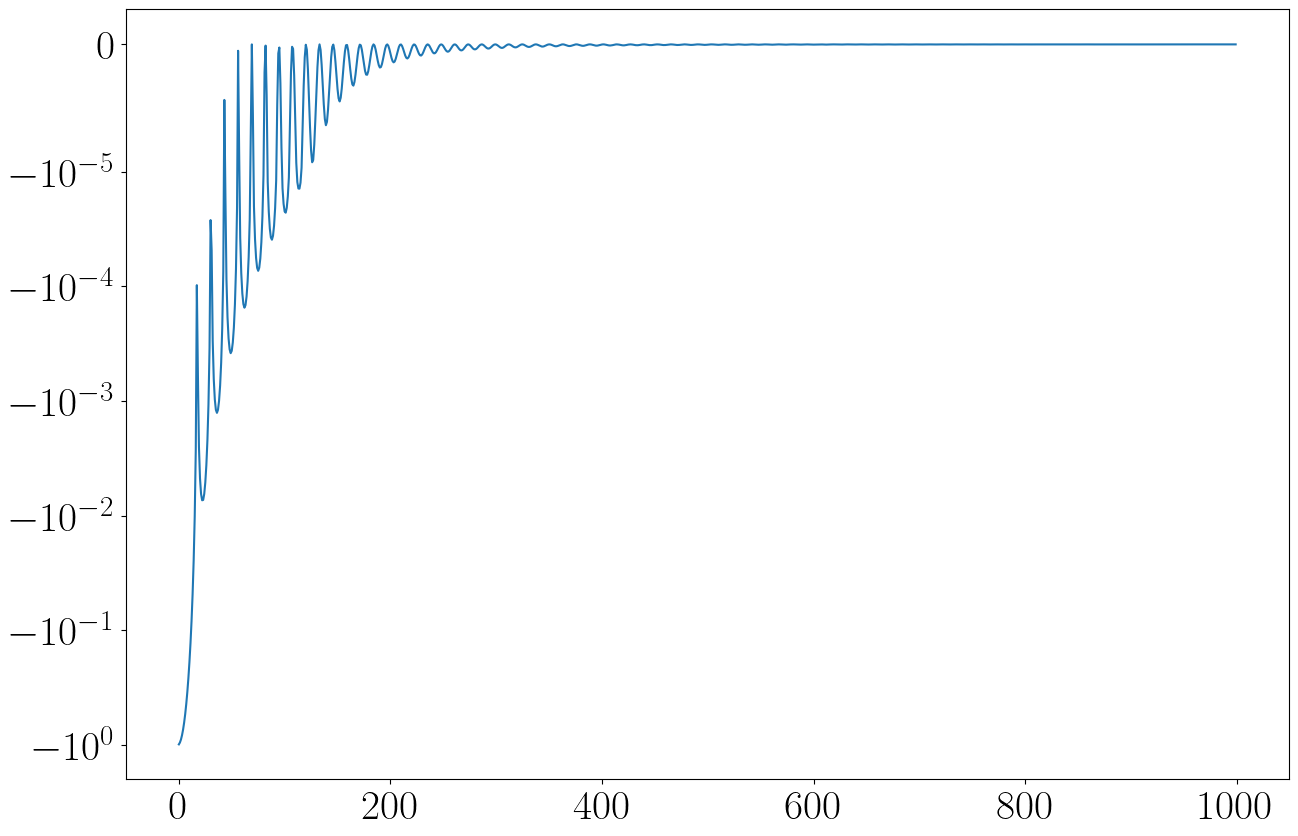

In [79]:
from atomic_forces.atomOFDFT.python.physics import ThomasFermi
from scipy.optimize import root
from scipy.integrate import quad

def find_η(Te, ne):
    """
    Gets chemical potential in [AU] that gives density ne at temperature Te
    """
    f_to_min = lambda η: ThomasFermi.n_TF(Te, η)-ne # η = βμ in ideal gas, no potential case
    
    root_and_info = root(f_to_min, 0.4,tol=1e-4)

    η = root_and_info['x'][0]
    return η

def h_ee_ID(ne, T, r, η):
    sin_arg = np.sqrt(2*T*m_e)*r
    t_max = 5*η#np.max([1/sin_arg, η ])
    
    # t = np.linspace(0,t_max, num=10000) 
    # dt = t[1]-t[0]
    # κ = 3*(2*T*m_e) / (atom.qsp.k_F**3 * r)  * np.sum(dt* t*np.sin(sin_arg*t) /(1+np.exp(t**2-η) )  )
    integrand = lambda t: t*np.sin(sin_arg*t)/(1+np.exp(t**2-η))
    κ = 3*(2*T*m_e) / (atom.qsp.k_F**3 * r) *quad(integrand, 0, t_max)[0]
    # h_ee = -0.5*κ**2
    h_ee = -κ**2
    return h_ee
    

η = find_η(Te_AU, atom.qsp.ne )
h_ee_ID_explicit = np.array([h_ee_ID(atom.qsp.ne, Te_AU, r*atom.qsp.ri, η ) for r in atom.hnc.r_array])

fig, ax = plt.subplots()

ax.plot(h_ee_ID_explicit)
ax.set_yscale('symlog', linthresh=1e-5)

In [80]:
t = np.linspace(0,1000, num=10000) 
k = np.linspace(0,1000, num=10000)
dt = t[1]-t[0]
dk = k[1]-k[0]
print("ne==", 2*4*π * (2*m_e*Te_AU)**(3/2) /(2*π)**3 * np.sum( dt* t**2 /(1+np.exp( t**2-η) )  ) )
print("ne==", 2*4*π /(2*π)**3 * np.sum( dk* k**2 /(1+np.exp( 1/(2*Te_AU*m_e)* k**2-η)) ) ) 
print("ne_TF == ", ThomasFermi.n_TF(Te_AU, η))

ne== 0.03122004737718369
ne== 0.028885202032148727
ne_TF ==  0.03119288176630919


/tmp/ipykernel_80461/3808811664.py:5: RuntimeWarning: overflow encountered in exp
  print("ne==", 2*4*π * (2*m_e*Te_AU)**(3/2) /(2*π)**3 * np.sum( dt* t**2 /(1+np.exp( t**2-η) )  ) )
/tmp/ipykernel_80461/3808811664.py:6: RuntimeWarning: overflow encountered in exp
  print("ne==", 2*4*π /(2*π)**3 * np.sum( dk* k**2 /(1+np.exp( 1/(2*Te_AU*m_e)* k**2-η)) ) )


In [81]:
f_of_k = 1/(  1+np.exp((atom.hnc.k_array/atom.qsp.ri)**2/(2*m_e*Te_AU) - η) )
# h_ee_ID_DST = -0.5* qsp.ri**-6*atom.hnc.FT_k_2_r(f_of_k)**2/(0.5*qsp.ne)**2
h_ee_ID_DST = - atom.qsp.ri**-6*atom.hnc.FT_k_2_r(f_of_k)**2/(0.5*atom.qsp.ne)**2
h_ee_ID_DST[-30:]

/tmp/ipykernel_80461/1089277479.py:1: RuntimeWarning: overflow encountered in exp
  f_of_k = 1/(  1+np.exp((atom.hnc.k_array/atom.qsp.ri)**2/(2*m_e*Te_AU) - η) )


array([-2.95002754e-09, -4.46437917e-09, -5.67059477e-09, -6.28509205e-09,
       -6.16450149e-09, -5.33872315e-09, -4.00315151e-09, -2.47207160e-09,
       -1.10433791e-09, -2.18907690e-10, -2.01064585e-11, -5.50133055e-10,
       -1.67984057e-09, -3.13979471e-09, -4.58414525e-09, -5.67217282e-09,
       -6.14828711e-09, -5.90169695e-09, -4.99182533e-09, -3.63364409e-09,
       -2.14653935e-09, -8.78867138e-10, -1.26017150e-10, -6.12531327e-11,
       -6.95518893e-10, -1.87553055e-09, -3.32044675e-09, -4.68834798e-09,
       -5.65679181e-09, -5.99846860e-09])

# Compare to 
### "Simple Classical Mapping of the Spin-Polarized Quantum Electron Gas: Distribution Functions and Local-Field Corrections" - Dharma-Wardana

In [82]:
def get_β_cP(h_r): #Pauli potential
    h_k = atom.hnc.FT_r_2_k(h_r)

    I_plus_h_rho_inverse = 1/(1 + 0.5*h_k*atom.hnc.rho[0])
    c_k = I_plus_h_rho_inverse * h_k
    c_r = atom.hnc.FT_k_2_r(c_k)

    # Approximate with HNC
    β_cP   = h_r - c_r -np.log(h_r+1)
    return β_cP

β_cP_DST = get_β_cP(h_ee_ID_DST)
β_cP_explicit = get_β_cP(h_ee_ID_explicit)

In [83]:
DW_gee_T0_data = read_csv("/home/zach/plasma/datasets/RDFs/gee_T=0.txt",delim_whitespace=True, header=1)
DW_βP_T0_data = read_csv("/home/zach/plasma/datasets/RDFs/βPee_T=0.txt",delim_whitespace=True, header=1)
# DW_gee_T0_data = read_csv("/home/zach/plasma/datasets/RDFs/gee_T=2EF.txt",delim_whitespace=True, header=1)
# DW_βP_T0_data = read_csv("/home/zach/plasma/datasets/RDFs/βPee_T=2EF.txt",delim_whitespace=True, header=1)

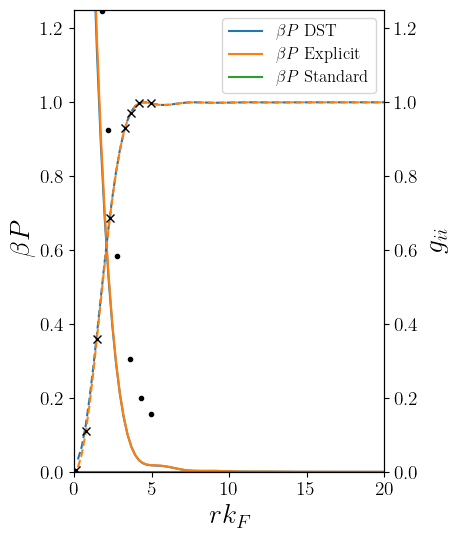

In [84]:
fig, ax = plt.subplots(figsize=(4,6))

ax.plot(atom.hnc.r_array*atom.qsp.k_F*atom.qsp.ri, β_cP_DST,color=colors[0], label=r'$\beta P$ DST')
ax.plot(atom.hnc.r_array*atom.qsp.k_F*atom.qsp.ri, β_cP_explicit,color=colors[1], label=r'$\beta P$ Explicit')
ax.plot(atom.hnc.r_array, atom.qsp.βv_Pauli(atom.hnc.r_array),color=colors[2],label=r'$\beta P$ Standard')
ax.plot(DW_βP_T0_data['rkF'], DW_βP_T0_data['βP_ee'],'k.')
ax2 = ax.twinx()
ax2.plot(atom.hnc.r_array*atom.qsp.k_F*atom.qsp.ri, h_ee_ID_DST +1,'--',color=colors[0])
ax2.plot(atom.hnc.r_array*atom.qsp.k_F*atom.qsp.ri, h_ee_ID_explicit +1,'--',color=colors[1])
ax2.plot(DW_gee_T0_data['rkF'], DW_gee_T0_data['gee'],'kx')
# ax2.plot(atom.hnc.r_array*atom.qsp.k_F*atom.qsp.ri, h_ee_ID_explicit+1)
# ax.set_xscale('log')

ax2.set_ylim(0,1.25)
ax.set_ylim(0,1.25)
ax.set_xlim(0,20)
ax.set_xlabel(r"$r k_F$",fontsize=20)
ax.set_ylabel(r"$\beta P $",fontsize=20)
ax2.set_ylabel(r"$g_{ii} $",fontsize=20)
ax.tick_params(labelsize=14)
ax2.tick_params(labelsize=14)
ax.legend(fontsize=12)

# Invert HNC

In [87]:
# def get_β_cP(h_r): #Pauli potential
#     h_r_matrix = np.array([[h_r, 0*h_r],[0*h_r, h_r]])
#     h_k_matrix = atom.hnc.FT_r_2_k_matrix(h_r_matrix)
#     rho_matrix = 0.5*np.array([atom.hnc.rho[1], atom.hnc.rho[1]])
    
#     I_plus_h_rho_inverse = atom.hnc.invert_matrix(atom.hnc.I[:,:,np.newaxis] + h_k_matrix*rho_matrix[:,np.newaxis,np.newaxis])#1/(1 + h_k*atom.hnc.rho[0])
#     c_k = atom.hnc.A_times_B(  I_plus_h_rho_inverse, h_k_matrix)
#     c_r = atom.hnc.FT_k_2_r_matrix(c_k)

#     # Approximate with HNC
#     β_cP   = h_r - c_r -np.log(h_r+1)
#     return β_cP

# β_cP_DST = get_β_cP(h_ee_ID_DST)
# # β_cP_explicit = get_β_cP(h_ee_ID_explicit)

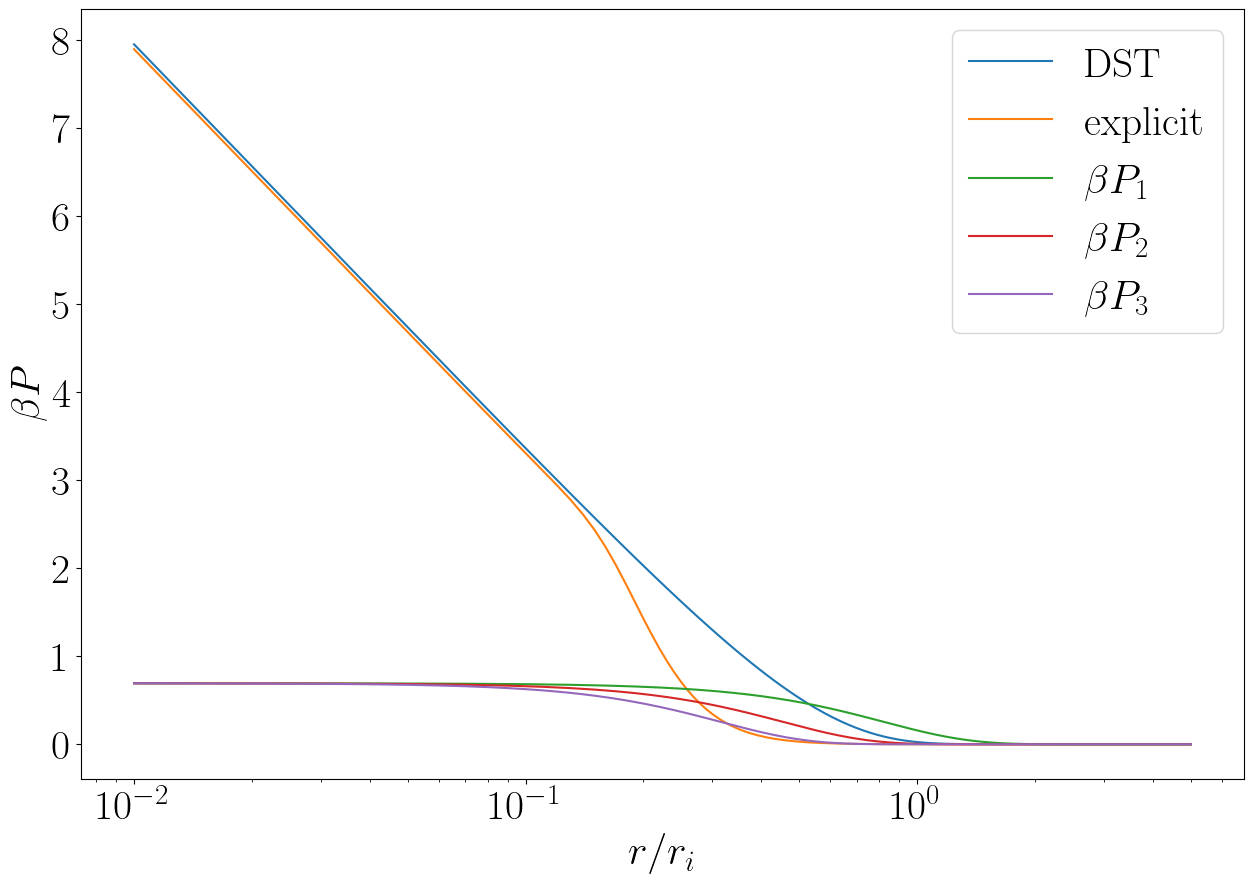

In [139]:
fig, ax = plt.subplots()

ax.plot(atom.hnc.r_array, β_cP_DST, label='DST')
ax.plot(atom.hnc.r_array, β_cP_explicit,label='explicit')
ax.plot(atom.hnc.r_array, qsp.βv_Pauli(atom.hnc.r_array, qsp.Λee),label=r'$\beta P_1$')
Λee_test = 1/np.sqrt(2*π*(m_e/2)*atom.qsp.Te_c )/atom.qsp.ri 
ax.plot(atom.hnc.r_array, np.log(2)*np.exp(-np.log(2)*atom.hnc.r_array**2/(π*Λee_test**2)),label=r'$\beta P_2$'  )
ax.plot(atom.hnc.r_array, np.log(2)*np.exp(-atom.hnc.r_array**2/(π*np.log(2)*Λee_test**2)),label=r'$\beta P_3$'  )
# ax.set_yscale('log')
ax.set_xscale('log')

# ax.set_ylim(1e-1,1e0)
ax.set_ylabel(r'$\beta P$')
ax.set_xlabel(r'$r/r_i$')
ax.legend()

In [51]:
from scipy.special import erfc

def Slater_S(Γ):
    ymax = 100
    ymin = 0.01*π*np.sqrt(Γ*qsp.re)
    N = int(ymax/ymin)
    print(N)
    y = np.linspace(0,1e2,num=N)
    dy = y[1]-y[0]
    return -4* np.sqrt(π*Γ*qsp.re) * np.sum(dy* np.exp(-y**2)*y/(1 - np.exp(π*np.sqrt(Γ*qsp.re)/y )  ) )

def β_cΔ(Γ, x): 
    """
    x=r/r_e   
    """
    a = np.sqrt(qsp.re/Γ)
    γ = -np.sqrt(π*Γ*qsp.re)/np.log(Slater_S(Γ))
#     return Γ/x*( 1 - np.exp(-a**2*x**2) + np.sqrt(π)*a*x *erfc(a*x))
    return Γ/x*( 1 - np.exp(-a**2*x**2) + np.sqrt(π)*a*x/γ *erfc(γ*a*x))
    
def Γc():
    Γ = 1/(qsp.Te*qsp.re)
    ωp = np.sqrt(4*π*qsp.ne/m_e)
    return 2*Γ*qsp.Te * np.tanh(ωp/(2*qsp.Te))/( ωp  )

1710


/tmp/ipykernel_7200/3922971775.py:10: RuntimeWarning: divide by zero encountered in divide
  return -4* np.sqrt(π*Γ*qsp.re) * np.sum(dy* np.exp(-y**2)*y/(1 - np.exp(π*np.sqrt(Γ*qsp.re)/y )  ) )


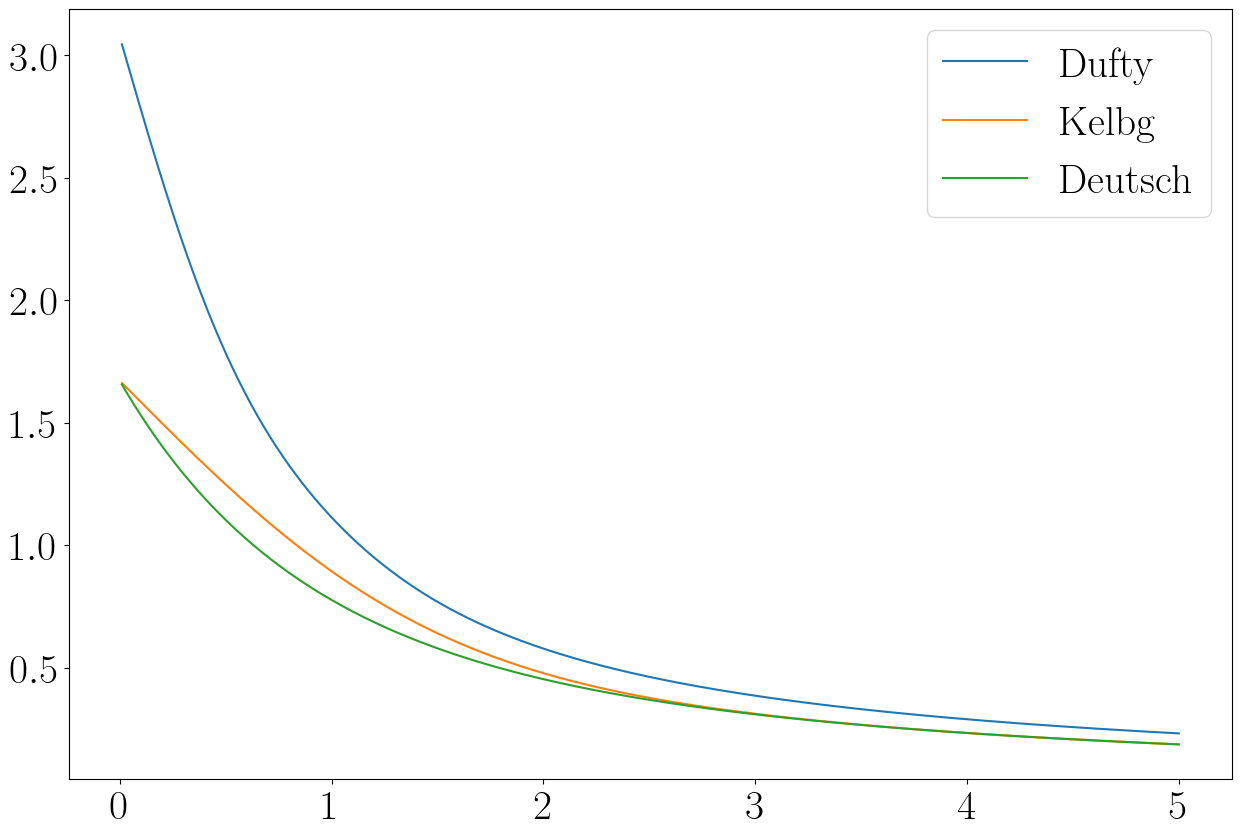

In [53]:
fig, ax = plt.subplots()

ax.plot(atom.hnc.r_array, β_cΔ(Γc(), atom.hnc.r_array*qsp.ri/qsp.re ),label= "Dufty")
ax.plot(atom.hnc.r_array, qsp.βv_Kelbg(qsp.Γee, atom.hnc.r_array, qsp.Λee), label='Kelbg')
ax.plot(atom.hnc.r_array, qsp.βv_Deutsch(qsp.Γee, atom.hnc.r_array, qsp.Λee),label='Deutsch')
# ax.plot(atom.hnc.r_array, qsp.βv_Kelbg(Γc(), atom.hnc.r_array, qsp.Λee))
ax.legend()

In [20]:
np.savetxt("βvee.txt",np.array([atom.hnc.r_array, β_cP_DST + β_cΔ(Γc(), atom.hnc.r_array*qsp.ri/qsp.re )]).T)

1710


/tmp/ipykernel_42832/3922971775.py:10: RuntimeWarning: divide by zero encountered in divide
  return -4* np.sqrt(π*Γ*qsp.re) * np.sum(dy* np.exp(-y**2)*y/(1 - np.exp(π*np.sqrt(Γ*qsp.re)/y )  ) )


In [13]:
βu_r_matrix = np.array([[β_cP_DST + β_cΔ(Γc(), atom.hnc.r_array*qsp.ri/qsp.re ) ]])

atom.hnc.set_βu_matrix(βu_r_matrix)
atom.hnc.initialize_c_k()
atom.hnc.set_C_matrix()
atom.hnc.HNC_solve(alpha_method='best', alpha_Picard = 1e-2, alpha_oz = 1e-4, h_max=1e4)
h_r_DST = atom.hnc.h_r_matrix[0,0]

βu_r_matrix = np.array([[β_cP_explicit + β_cΔ(Γc(), atom.hnc.r_array*qsp.ri/qsp.re ) ]])

atom.hnc.set_βu_matrix(βu_r_matrix)
atom.hnc.initialize_c_k()
atom.hnc.set_C_matrix()
atom.hnc.HNC_solve(alpha_method='best', alpha_Picard = 1e-2, alpha_oz = 1e-4, h_max=1e4)
h_r_explicit = atom.hnc.h_r_matrix[0,0]

1710
 HNC min: [0.5] True Optimization terminated successfully.
0: Err in c_r: 7.19e-02, OZ: 1.01e-01, HNC: 1.88e-02
 HNC min: [0.5] True Optimization terminated successfully.
1: Err in c_r: 4.28e-02, OZ: 1.04e-01, HNC: 9.86e-03
 HNC min: [0.5] True Optimization terminated successfully.
2: Err in c_r: 2.55e-02, OZ: 1.06e-01, HNC: 5.58e-03
 HNC min: [0.5] True Optimization terminated successfully.
3: Err in c_r: 1.53e-02, OZ: 1.07e-01, HNC: 3.30e-03
 HNC min: [0.5] True Optimization terminated successfully.
4: Err in c_r: 9.24e-03, OZ: 1.08e-01, HNC: 2.00e-03
 HNC min: [0.5] True Optimization terminated successfully.
5: Err in c_r: 5.63e-03, OZ: 1.08e-01, HNC: 1.24e-03
 HNC min: [0.5] True Optimization terminated successfully.
6: Err in c_r: 3.45e-03, OZ: 1.08e-01, HNC: 7.72e-04
 HNC min: [0.5] True Optimization terminated successfully.
7: Err in c_r: 2.13e-03, OZ: 1.09e-01, HNC: 4.87e-04


/tmp/ipykernel_42832/3922971775.py:10: RuntimeWarning: divide by zero encountered in divide
  return -4* np.sqrt(π*Γ*qsp.re) * np.sum(dy* np.exp(-y**2)*y/(1 - np.exp(π*np.sqrt(Γ*qsp.re)/y )  ) )


 HNC min: [0.5] True Optimization terminated successfully.
8: Err in c_r: 1.33e-03, OZ: 1.09e-01, HNC: 3.09e-04
 HNC min: [0.5] True Optimization terminated successfully.
9: Err in c_r: 8.34e-04, OZ: 1.09e-01, HNC: 1.97e-04
 HNC min: [0.5] True Optimization terminated successfully.
10: Err in c_r: 5.25e-04, OZ: 1.09e-01, HNC: 1.26e-04
 HNC min: [0.5] True Optimization terminated successfully.
11: Err in c_r: 3.33e-04, OZ: 1.09e-01, HNC: 8.06e-05
 HNC min: [0.5] True Optimization terminated successfully.
12: Err in c_r: 2.11e-04, OZ: 1.09e-01, HNC: 5.17e-05
 HNC min: [0.5] True Optimization terminated successfully.
13: Err in c_r: 1.35e-04, OZ: 1.09e-01, HNC: 3.33e-05
 HNC min: [0.5] True Optimization terminated successfully.
14: Err in c_r: 8.62e-05, OZ: 1.09e-01, HNC: 2.14e-05
 HNC min: [0.5] True Optimization terminated successfully.
15: Err in c_r: 5.52e-05, OZ: 1.09e-01, HNC: 1.38e-05
 HNC min: [0.5] True Optimization terminated successfully.
16: Err in c_r: 3.54e-05, OZ: 1.09e-01,

(0.0, 1.5)

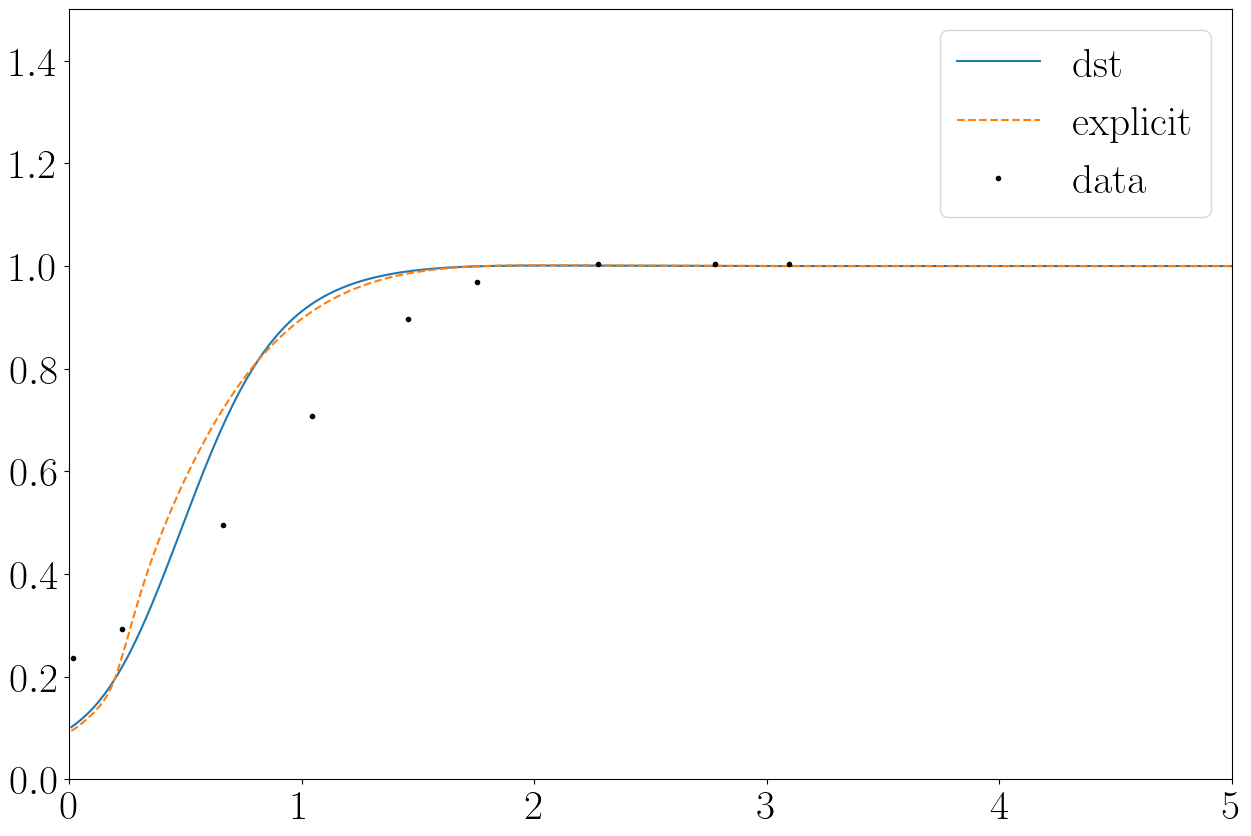

In [14]:
fig, ax = plt.subplots()
DD_data_rs1_t1 = np.array([[0.015915119363395226, 0.22208955223880597],
[0.16710875331564987, 0.2740298507462687 ],
[0.42572944297082227, 0.4298507462686567 ],
[0.7519893899204244, 0.6698507462686567 ],
[1.0145888594164456, 0.8202985074626866 ],
[1.3647214854111407, 0.9223880597014925 ],
[1.9456233421750664, 0.9779104477611941 ],
[2.944297082228117, 1.0011940298507462  ]]).T

DD_data_rs40_t8 = np.array([[0.09767441860465116, 0.002628120893561104 ],
[0.3697674418604651, 0.02759526938239159  ],
[0.5895348837209302, 0.16294349540078845  ],
[0.8093023255813954, 0.4231274638633377  ],
[1.0186046511627906, 0.6649145860709593  ],
[1.1651162790697673, 0.7936925098554534  ],
[1.3813953488372093, 0.9132720105124836  ],
[1.744186046511628, 0.9894875164257556  ],
[2.644186046511628, 1.0052562417871223  ]]).T

DD_data_rs1_t0p0625 = np.array([[0.015810276679841896, 0.2360060514372163],
[0.2292490118577075, 0.291981845688351   ],  
[0.6600790513833992, 0.4962178517397882  ],  
[1.0434782608695652, 0.708018154311649   ], 
[1.4584980237154148, 0.897125567322239   ],  
[1.7549407114624505, 0.9697428139183056  ], 
[2.276679841897233, 1.0030257186081695   ],
[2.7786561264822134, 1.0030257186081695  ], 
[3.0948616600790513, 1.0030257186081695  ]]).T

ax.plot(atom.hnc.r_array, h_r_DST+1,'-', label='dst')
ax.plot(atom.hnc.r_array, h_r_explicit+1,'--',label='explicit')
# ax.plot(DD_data_rs1_t1[0],DD_data_rs1_t1[1],'k.',label='data')
# ax.plot(DD_data_rs40_t8[0],DD_data_rs40_t8[1],'k.',label='data')
ax.plot(DD_data_rs1_t0p0625[0],DD_data_rs1_t0p0625[1],'k.',label='data')
ax.legend()
ax.set_xlim(0,5)
ax.set_ylim(0,1.5)